### Introduction

Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.

Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

In this competition, Mercari’s challenging you to build an algorithm that automatically suggests the right product prices. You’ll be provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.

### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline 

//anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Loading Data

In [ ]:
train = pd.read_csv('data download/train.tsv',sep = '\t')
test = pd.read_csv('data download/test.tsv',sep = '\t')

### Exploratory Data Analysis

* #### Overview

In [12]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [13]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


* #### Size

In [11]:
print('The training set has {} instances and {} features'.format(train.shape[0],train.shape[1]))
print('The testing set has {} instances and {} features'.format(test.shape[0],test.shape[1]))

The training set has 1482535 instances and 8 features
The testing set has 693359 instances and 7 features


* #### Dependent and Independent Variables

In [23]:
ind_var = list(train.columns)
ind_var.remove('price')
print('Independent variables are: \n',ind_var)
print('Dependent variable is: \n',['price'])

Independent variables are: 
 ['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name', 'shipping', 'item_description']
Dependent variable is: 
 ['price']


train_id or test_id: The id of the listing

name: The title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

item_condition_id: The condition of the items provided by the seller

category_name: Category of the listing

brand_name: Name of the brand

price: The price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.

shipping: 1 if shipping fee is paid by seller and 0 by buyer

item_description: The full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

* #### Data Types

In [34]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

There are 3 integer type variables(train_id, item_condition_id, and shipping), 1 float type variable(price), and 4 text type variables(name, category_name, brand_name, and item_description). By investigating them one by one, we would be able to determine whether one is numerical variable, ordinal variable, or categorical variable. 

* #### Variable Types

In [38]:
print('The unique values in the column of train_id:\n',train['train_id'].unique())
print('The total number of unique values in the column of train_id:\n',train['train_id'].nunique())
assert train['train_id'].nunique() == train.shape[0]

The unique values in the column of train_id:
 [      0       1       2 ..., 1482532 1482533 1482534]
The total number of unique values in the column of train_id:
 1482535


The number of unique values in the train_id column is just the number of instances in the data set. The value of this column is a duplicate of the dataframe index. Although it is a categorical feature, there is barely any information that could be gained from this feature.

In [39]:
print('The unique values in the column of name:\n',train['name'].unique())
print('The total number of unique values in the column of name:\n',train['name'].nunique())

The unique values in the column of name:
 ['MLB Cincinnati Reds T Shirt Size XL' 'Razer BlackWidow Chroma Keyboard'
 'AVA-VIV Blouse' ..., '21 day fix containers and eating plan'
 'World markets lanterns' 'Brand new lux de ville wallet']
The total number of unique values in the column of name:
 1225273


Obviously the name is a categorical feature as it contains the name od each item. However, the total numbers of unique names is far less than the number of instances in the training set, which means huge nimber of duplicates exist in the name column. We might check those values later.

In [40]:
print('The unique values in the column of item_condition_id:\n',train['item_condition_id'].unique())
print('The total number of unique values in the column of item_condition_id:\n',train['item_condition_id'].nunique())

The unique values in the column of item_condition_id:
 [3 1 2 4 5]
The total number of unique values in the column of item_condition_id:
 5


This is an ordinal variable. There are only five unique values, indicating the usage condition of the items. And the number itself may infer how much the item worth. These reasons make it an ordinal variable.

In [42]:
print('The unique values in the column of category_name:\n',train['category_name'].unique())
print('The total number of unique values in the column of category_name:\n',train['category_name'].nunique())

The unique values in the column of category_name:
 ['Men/Tops/T-shirts' 'Electronics/Computers & Tablets/Components & Parts'
 'Women/Tops & Blouses/Blouse' ..., 'Handmade/Jewelry/Clothing'
 'Vintage & Collectibles/Supplies/Ephemera' 'Handmade/Pets/Blanket']
The total number of unique values in the column of category_name:
 1287


Only 1287 categories are listed in the column of category_name. This is not surprising since many items can be from the same category. This is a categorical feature.

In [43]:
print('The unique values in the column of brand_name:\n',train['brand_name'].unique())
print('The total number of unique values in the column of brand_name:\n',train['brand_name'].nunique())

The unique values in the column of brand_name:
 [nan 'Razer' 'Target' ..., 'Astroglide' 'Cumberland Bay' 'Kids Only']
The total number of unique values in the column of brand_name:
 4809


The column of brand_name has a similar condition with category_name. It is also a categorical feature.

In [49]:
print('The unique values in the column of price:\n',train['price'].unique())
print('The total number of unique values in the column of price:\n',train['price'].nunique())

The unique values in the column of price:
 [   10.     52.     35.     44.     59.     64.      6.     19.      8.
    34.     16.      4.     43.     11.     29.     25.     27.     13.
    20.    386.     66.     24.      5.     32.     50.     22.    209.
   226.     14.     12.     51.     21.     54.      9.    114.     36.
    28.      7.    119.     15.     45.     61.     26.     17.     18.
    39.      3.    150.     81.     49.     41.     38.     31.     60.
    40.    250.     79.    104.    145.     23.     91.     47.     30.
    46.     71.     55.     70.    470.    129.     94.    109.     56.
    80.    650.    124.     42.    131.     69.     76.     33.    106.
   165.    100.     74.    506.     95.    271.    140.     73.     65.
   120.     62.     37.    116.     75.     90.    115.     84.    589.
   155.    249.    304.     72.     89.     68.    350.    136.    110.
   134.     86.     57.    186.      0.    305.    306.     67.    310.
   206.     58.    24

Price is a numerical feature. However, there are only 828 unique values in price. It infers that there maybe some dense area in the distribution of the price.

In [50]:
print('The unique values in the column of shipping:\n',train['shipping'].unique())
print('The total number of unique values in the column of shipping:\n',train['shipping'].nunique())

The unique values in the column of shipping:
 [1 0]
The total number of unique values in the column of shipping:
 2


This is obviously a categorical feature with only two categories.

In [51]:
print('The unique values in the column of item_description:\n',train['item_description'].unique())
print('The total number of unique values in the column of item_description:\n',train['item_description'].nunique())

The unique values in the column of item_description:
 ['No description yet'
 'This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.'
 'Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!'
 ..., 'Used once or twice, still in great shape.'
 'There is 2 of each one that you see! So 2 red 2 orange and 2 of the big red and orange ones! They are from world market!'
 'New with tag, red with sparkle. Firm price, no free shipping.']
The total number of unique values in the column of item_description:
 1281426


This is a feature similar to category_name and brand_name. The difference is that many more unique values appear in this feature. Since descriptions are considered less likely to be duplicates, we believe there maybe some missing values. Despite more investigation is needed, it can be confirmed that this is a categorical feature.

* #### Missing Value

In [55]:
print('Number of null values in each column:')
print(train.isnull().sum())

Number of null values in each column:
train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64


In [56]:
print('Percentage of null values in each column:')
print(train.isnull().sum()/train.shape[0])

Percentage of null values in each column:
train_id             0.000000
name                 0.000000
item_condition_id    0.000000
category_name        0.004268
brand_name           0.426757
price                0.000000
shipping             0.000000
item_description     0.000003
dtype: float64


We got five columns that are null value free, train_id, name, item_condition, price, and shipping. Missing values appear more or less in other 3 columns, category_name, brand_name, and item_description. The column with the most null values is brand_name, with around 40 percent of records being null values. A small proportion of records have null values in category_name column. Only 4 items miss their item_description. We should be cautious when dealing with brand_name as so many missing values appear in this column. 

* #### Statistical Investigation

Here, we are going to investigate the features statistically one by one to get more insights from the data. Among all the independent variables, the train_id is not offering information more than index, so we would just skip that column. The scope would be 6 independent variables and 1 dependent variable. We would start with the dependent variable.

### 1.price column

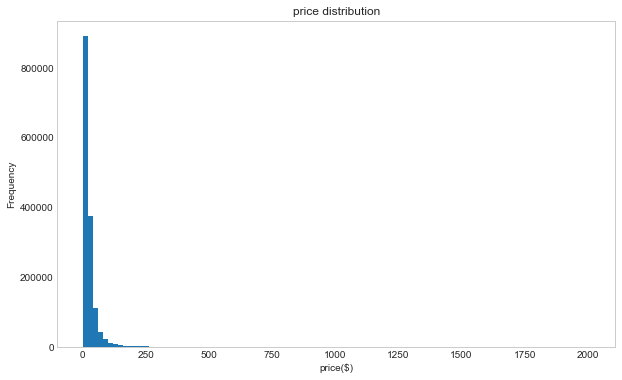

statistics:

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64


In [257]:
plt.figure(figsize = (10,6))
train['price'].plot(kind = 'hist',bins = 100)
plt.title('price distribution')
plt.xlabel('price($)')
plt.grid(b=False)
plt.show()
print('statistics:\n')
print(train['price'].describe())

It seems the price is heavily right skewed. Most items are tagged with price lower than \$100. We noticed, however, the range of the plot indicats that there are items with extreme high prices as much as more than \$2000. But the right skewed shape is telling that the number of items with highe price is very limited. And from the statistics we know that the max price is \$2009, which is in accordance with the histgram. The mean price is \$26.7. However, it shows that the minimun price is \$0, which is weird. We are going to check these in detail. 

In [64]:
print('The number of items with price higher than $500: {}'.format(np.where(train['price']>500,True,False).sum()))

The number of items with price higher than $500: 1115


As we discussed, the proportion of high price items is very small. There are only 1115 items whose prices are higher than \$500.

In [75]:
train[np.where(train['price']>2000,True,False)]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
760469,760469,NEW Chanel WOC Caviar Gold Hardware,1,Women/Women's Handbags/Shoulder Bag,Chanel,2009.0,0,"New with tag, box and dustbag but no receipt. ..."
1262245,1262245,NEW-Chanel Boy Wallet o Chain WOC Caviar,1,Women/Women's Handbags/Messenger & Crossbody,Chanel,2006.0,0,Brand: Chanel Style: WOC Boy Wallet on Chain T...
1393600,1393600,David Yurman Wheaton ring,2,Women/Jewelry/Rings,David Yurman,2004.0,0,David Yurman Wheaton wing. Size 6. Original re...


To make sure these high price items are not outliers, we zoomed into the data and filtered out the items with prices higher than $2000. We found that these items come from luxury brands such as Chanel and David Yurman. They deserve the high price for sure. So, now we can tell these records are indeed not outliers.

Also, we noticed from the statistics that the minimum value in price column is 0. We are going to check these records.

In [74]:
print('The number of items with price of $0: {}'.format(np.where(train['price']==0,True,False).sum()))

The number of items with price of $0: 874


In [76]:
train[np.where(train['price']==0,True,False)]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1325,1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,NaN,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
2544,2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2712,2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,NaN,0.0,0,"Very simple but cute, a little form fitting as..."
3576,3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,0.0,1,1 left!
3761,3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,NaN,0.0,1,5 pair gap jean excellent used condition 3 chi...
5237,5237,Nursing Bra,3,Women/Underwear/Bras,Motherhood Maternity,0.0,0,Used a few times but was not able to nurse
6175,6175,"Multi Listing Bundled Package, Thanks",2,Electronics/Media/DVD,NaN,0.0,1,1)Large Collection of Full Length Strawberry S...
7116,7116,Nike Dri-Fit High Power Speed Tights,1,"Women/Athletic Apparel/Pants, Tights, Leggings",Nike,0.0,1,"Bought at Nike store in New York, Brand New, N..."
7622,7622,Hands free earpiece,1,Electronics/Cell Phones & Accessories/Headsets,NaN,0.0,0,Wireless Bluetooth hands free used with Samsun...
10812,10812,Vampire candy bowl,1,Home/Seasonal Décor/Halloween,NaN,0.0,0,New good condition for halloween


That is weird as these items seem normal items. It makes no sense that the vendors sell them for free, not to say some of them even provide shipping fees. They could be missing values if their true price were lost for some reason. They could also be outliers if the vendors indeed were selling them for free, cause these records would be noises when building the model. As there is nothing common about these items, we would regard them more as outliers that should be eliminated during modeling. 

### 2.name column

As we discovered, the number of unique values in name column is far smaller than the number of records. So, we are going to identify what names are most frewuently used in our data set.

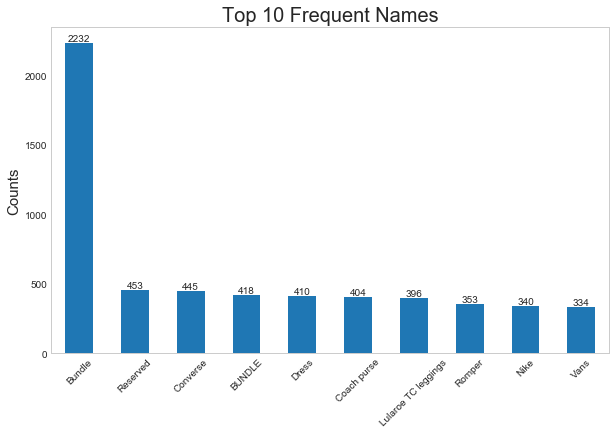

In [256]:
plt.figure(figsize = (10,6))
ax = train['name'].value_counts()[:10].plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.ylabel('Counts',fontsize = 15)
plt.title('Top 10 Frequent Names',fontsize = 20)
plt.grid(b=False)
for i in ax.patches:
    y_value = i.get_height()
    x_value = i.get_x()+i.get_width()/2
    plt.annotate(int(y_value),(x_value,y_value),ha = 'center',va = 'bottom')
plt.show()

Here, we found that the most frequently used names are vague names like 'Bundle', or brand names like 'Converse', 'Nike', or combinations of category and brand like 'Coach purse'. Now we can tell the reason for huge amount of duplicate values in name column is these vague names. Maybe the vendors are too lazy to make them more clear. We are curious about what exactly are 'Bundle' items.

In [132]:
train[train['name']=='Bundle']

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
122,122,Bundle,3,NaN,NaN,59.0,0,Sizes and info of clothes can be found on thei...
290,290,Bundle,1,Other/Other/Other,NaN,81.0,0,[rm] Discounted price [rm]
932,932,Bundle,1,Women/Sweaters/Poncho,NaN,26.0,0,1pc Oversize Turtle Neck Plaid Poncho Cape 1pc...
1053,1053,Bundle,3,Electronics/Video Games & Consoles/Games,Nintendo,22.0,1,Minor play scratches Played with condition Tha...
2158,2158,Bundle,2,"Women/Skirts/Straight, Pencil",NaN,36.0,1,Please check to see if its all
4729,4729,Bundle,3,Women/Tops & Blouses/T-Shirts,NaN,36.0,0,Bundle reserved for Evat
4806,4806,Bundle,3,Kids/Boys 2T-5T/Tops & T-Shirts,Gap,14.0,0,"White and orange are both Baby Gap, blue strip..."
6580,6580,Bundle,2,Women/Women's Handbags/Totes & Shoppers,Victoria's Secret,24.0,1,Bundle Free Shipping JEM
6841,6841,Bundle,2,Women/Other/Other,H&M,13.0,0,Just cleaning out my closet come with 2 tshirt...
8025,8025,Bundle,1,Other/Office supplies/Shipping Supplies,NaN,10.0,1,(8) XXL 14x17 Shipping Polymailers (8) 10x13 P...


It seems there is not much common conditions among these 'Bundle' items.

In [145]:
print("Mean price of 'Bundle' items: ${:.2f}".format(train[train['name']=='Bundle']['price'].mean()))
print("Mean price of all items: ${:.2f}".format(train['price'].mean()))

Mean price of 'Bundle' items: $34.50
Mean price of all items: $26.74


However, we found that the average price for 'Bundle' items are much higher than that for all items. Perhaps more sub-items are included in the bundles. And that makes the price higher than that of normal items.

### 3.item_condition_id column

No missing values appear in the item_condition_id column. And there are only 5 unique values in this column, from 1 to 5. And the number gets bigger as the item condition gets worse. First, we are going to check how many items are there in each condition group.

In [165]:
condition_count = train['item_condition_id'].value_counts()
print('Number of items in each condition category:')
print(condition_count)

Number of items in each condition category:
1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


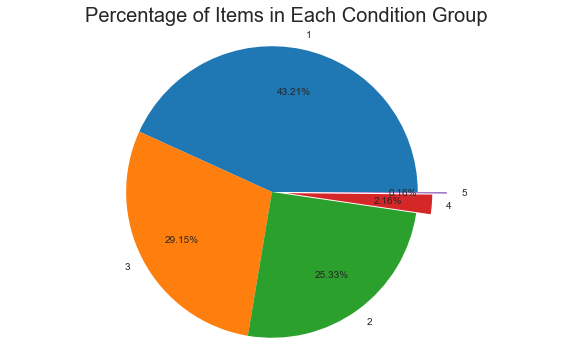

In [254]:
condition_percentage = train['item_condition_id'].value_counts()/train.shape[0]
plt.figure(figsize = (10,6))
ax2 = condition_percentage.plot(kind = 'pie',autopct='%1.2f%%',pctdistance = 0.7,explode = [0,0,0,0.1,0.2])
ax2.axis('equal')
plt.title('Percentage of Items in Each Condition Group',fontsize = 20)
plt.ylabel('')
plt.show()

Not surprising, the biggest group is 1 with 43.2% of items. It is not hard to assume that sellers are more likely to sell items with better conditions. And group 5 is the smallest one with only 0.16% of items. But how does the condition information related with the price. We would use a boxplot to demonstrate this relationship. For a better understanding of the plot, we will limit the range upon y axis.

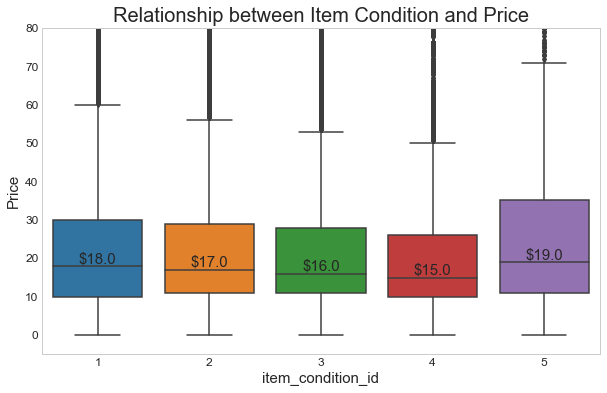

In [255]:
sns.set_style("whitegrid")
plt.figure(figsize = (10,6))
ax3 = sns.boxplot(x = 'item_condition_id',y = 'price',data = train)
ax3.set_ylim((-5,80))
medians = train.groupby('item_condition_id')['price'].median().values
for i in range(len(medians)):
    x_co = i
    y_co = medians[i]
    text_label = medians[i]
    plt.text(x_co,y_co,'$'+str(text_label),ha = 'center',va = 'bottom',size = 15)
plt.xlabel('item_condition_id',fontsize = 15)
plt.ylabel('Price',fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(b = False)
plt.title('Relationship between Item Condition and Price',fontsize = 20)

As the item condition gets worse, the median price gets lower, from \$18 to \$15. But the group of condition number 5 seems don't follow this trend as it bouncing back drastically with a median of \$19, even higher than the median of group 1. There maybe one explanation, that is, the size of the group 5 is far smaller than the other four groups. Thus, this situation is happened by chance. 

In [243]:
condition_five = train[train['item_condition_id']==5]
cf_topten = (condition_five['category_name'].value_counts()/condition_five.shape[0])[:10]
print(cf_topten)

Electronics/Cell Phones & Accessories/Cell Phones & Smartphones    0.221057
Electronics/Video Games & Consoles/Consoles                        0.072148
Electronics/Video Games & Consoles/Games                           0.060822
Men/Shoes/Athletic                                                 0.039010
Electronics/Computers & Tablets/Laptops & Netbooks                 0.032718
Kids/Toys/Dolls & Accessories                                      0.023909
Women/Women's Handbags/Shoulder Bag                                0.023490
Electronics/Computers & Tablets/iPad/Tablet/eBook Readers          0.020554
Electronics/Video Games & Consoles/Accessories                     0.015520
Women/Shoes/Sandals                                                0.014681
Name: category_name, dtype: float64


In [238]:
train[train['category_name']=='Electronics/Cell Phones & Accessories/Cell Phones & Smartphones']

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
22,22,Galaxy S7 Edge (Unlocked) 32GB,3,Electronics/Cell Phones & Accessories/Cell Pho...,Samsung,386.0,0,"Reasonable offers welcomed. But if you ask ""lo..."
149,149,LIKE NEW IPHONE 5C,2,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,104.0,0,Just Upgraded So Now Finally Getting Rid Of My...
320,320,Professional Precision Digital Scale,1,Electronics/Cell Phones & Accessories/Cell Pho...,NaN,12.0,0,RT-500 Professional Digital Mini Scale Precisi...
796,796,iPhone 4,3,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,30.0,1,Black iPhone 4 for Verizon comes with charger
1022,1022,Galaxy note 5 64 gb (read description),4,Electronics/Cell Phones & Accessories/Cell Pho...,Samsung,115.0,1,Color : black Description : 64 gb galaxy note ...
1330,1330,iPhone 6 64gb Gold (Sprint),3,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,305.0,1,Fully functional iPhone 6 64gb Rose Gold. Only...
1536,1536,iPhone 6 Plus,2,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,310.0,1,iPhone 6 Plus US Cellular. Clean ESN. Excellen...
1568,1568,Nike iPhone 7 rubber case,1,Electronics/Cell Phones & Accessories/Cell Pho...,NaN,16.0,0,"PRICE IS VERY FIRM , DONT ACCEPT ANY OFFER . D..."
1593,1593,iPhone 5c,3,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,34.0,0,Blue iPhone 5c Screen Was Recently Replaced An...
1597,1597,iPod touch 5th generation,4,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,31.0,0,Could use a new battery


By investigating detailly, we recognized that electronic products are the big part of group 5. Although there are elecronic products in other groups, the huge amount of other items does pull down the median price. Probabily, people are less likely to buy items except electronic when their conditions get heavily used.

### 4.category_name column

We are curious about what are the top ten categories to which items belong to.

In [274]:
top10_cat = train['category_name'].value_counts()[:10]
top10_cat_per = [str(np.round(i*100,2))+'%' for i in (train['category_name'].value_counts()/train.shape[0])[:10]]

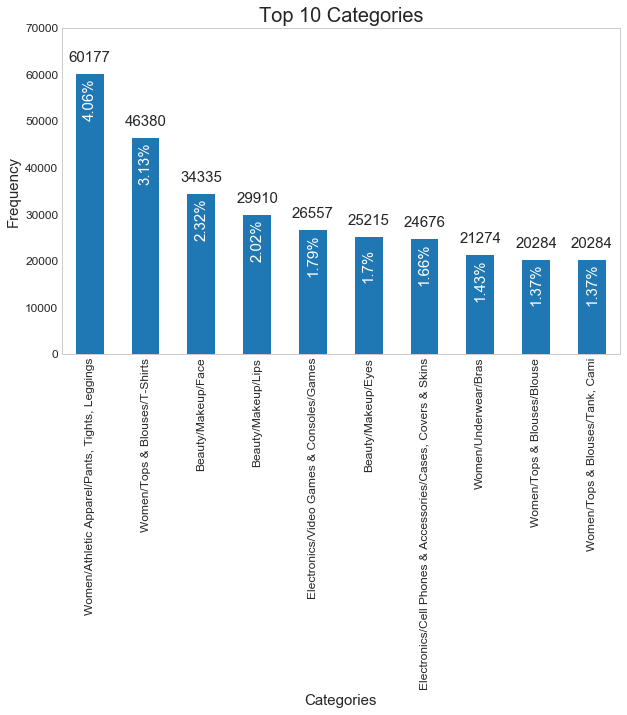

In [279]:
plt.figure(figsize = (10,6))
plt.ylim(0,70000)
ax4 = top10_cat.plot(kind = 'bar')
plt.grid(b = False)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.xlabel('Categories',fontsize = 15)
plt.ylabel('Frequency',fontsize  =15)
plt.title('Top 10 Categories',fontsize = 20)
for i,bar in enumerate(ax4.patches):
    x_co1 = bar.get_x()+bar.get_width()/2
    y_co1 = bar.get_height()+2000
    x_co2 = bar.get_x()+bar.get_width()/2
    y_co2 = bar.get_height()-10000
    plt.text(x_co1,y_co1,top10_cat[i],ha = 'center',size = 15,va = 'bottom')
    plt.text(x_co2,y_co2,top10_cat_per[i],ha = 'center',va = 'bottom',color = 'white',size = 15,rotation = 90)
    
plt.show()

This bar chart shows the top ten popular categories on sale in our data set. The most frequent one is women athletic apparel with a percentage of 4.06% among all the items. We also noticed that among all the top ten frequent categories, eight categories are woman related, which is an informative fact.   

Besides these we are also curious about what are the ten categories with highest mean price as well as what are the ten categories with lowest mean price.

In [299]:
cat_price_mean = train.groupby('category_name').agg({'price':'mean'})

In [305]:
top10_high = cat_price_mean.sort_values(by = 'price',ascending=False).iloc[:10,:]
top10_low = cat_price_mean.sort_values(by = 'price').iloc[:10,:]

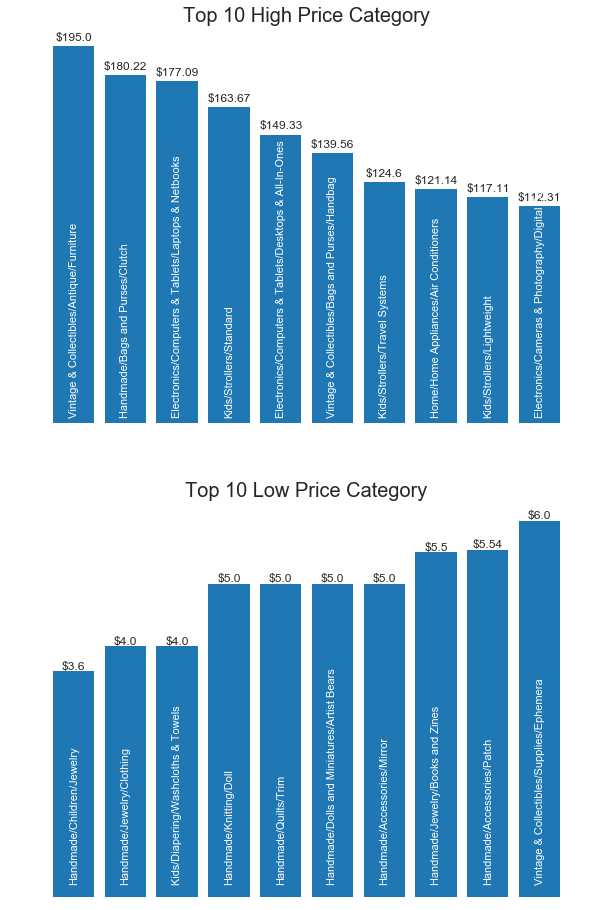

In [363]:
fig,(ax5,ax6) = plt.subplots(nrows = 2,figsize = (10,16))
ax5.grid(b = False)
ax6.grid(b = False)
a1 = ax5.bar(range(len(top10_high)),top10_high['price'])
a2 = ax6.bar(range(len(top10_low)),top10_low['price'])
ax5.set_xticks([])
ax6.set_xticks([])
ax5.set_title('Top 10 High Price Category',fontsize = 20)
ax6.set_title('Top 10 Low Price Category',fontsize = 20)
ax5.axis('off')
ax6.axis('off')
for i in range(len(top10_high)):
    x_co_price_high = a1.patches[i].get_x()+a1.patches[i].get_width()/2
    y_co_price_high = a1.patches[i].get_height()+2
    x_co_price_low = a2.patches[i].get_x()+a2.patches[i].get_width()/2
    y_co_price_low = a2.patches[i].get_height()
    x_co_cat_high = a1.patches[i].get_x()+a1.patches[i].get_width()/2
    y_co_cat_high = 3
    x_co_cat_low = a2.patches[i].get_x()+a2.patches[i].get_width()/2
    y_co_cat_low = 0.2
    ax5.text(x_co_price_high,y_co_price_high,'$'+str(np.round(top10_high['price'][i],2)),ha = 'center',va = 'bottom',size = 12)
    ax5.text(x_co_cat_high,y_co_cat_high,top10_high.index[i],ha = 'center',va = 'bottom',rotation = 90,size = 11,color = 'white')
    ax6.text(x_co_price_low,y_co_price_low,'$'+str(np.round(top10_low['price'][i],2)),ha = 'center',va = 'bottom',size = 12)
    ax6.text(x_co_cat_low,y_co_cat_low,top10_low.index[i],ha = 'center',va = 'bottom',rotation = 90,size = 11,color = 'white')

Now we got top ten high price categories and top ten low price categories. In the upper side, we can see bags, vintage, collections-maybe luxury sort of things, and electronic appliances, and kids stroller items with prices higher than $100. In the lower side, most things are handmade craft with price around 5 bucks.

### 5.brand_name column

For the brand_name, we also curious about which brands are the top frequent ones in our data set. Of course we have already identified that more than 40 percent of items have missing values in brand name, we will not take those null values into account when answer this question. 

In [381]:
top20_brand = train['brand_name'].value_counts()[:20]
top20_brand_per = [str(np.round(i*100,2))+'%' for i in (train['brand_name'].value_counts()/train.shape[0])[:20]]

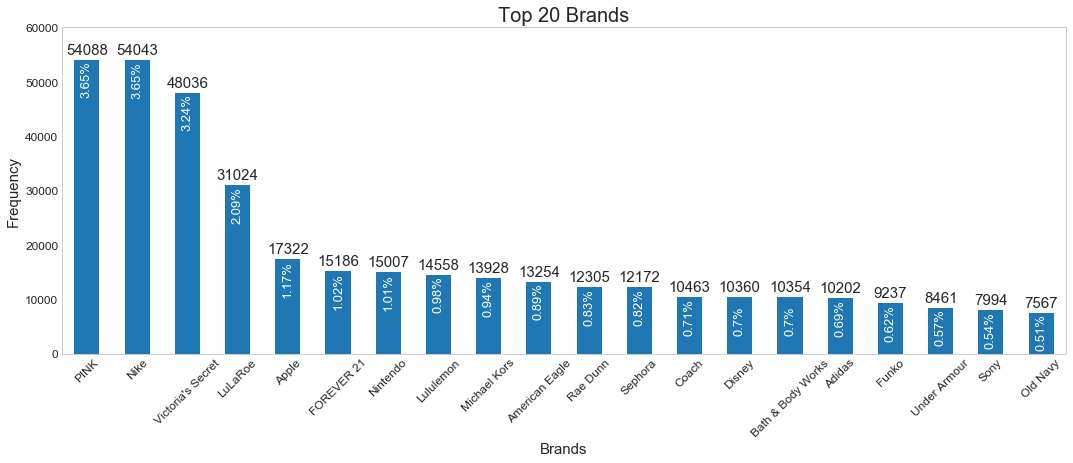

In [389]:
plt.figure(figsize = (18,6))
ax7 = top20_brand.plot(kind = 'bar')
plt.ylim(0,60000)
plt.grid(b = False)
plt.xticks(size = 12,rotation = 45)
plt.yticks(size = 12)
plt.xlabel('Brands',fontsize = 15)
plt.ylabel('Frequency',fontsize  =15)
plt.title('Top 20 Brands',fontsize = 20)
for i,bar in enumerate(ax7.patches):
    x_co1 = bar.get_x()+bar.get_width()/2
    y_co1 = bar.get_height()+500
    x_co2 = bar.get_x()+bar.get_width()/2
    y_co2 = bar.get_height()-7000
    plt.text(x_co1,y_co1,top20_brand[i],ha = 'center',size = 15,va = 'bottom')
    plt.text(x_co2,y_co2,top20_brand_per[i],ha = 'center',va = 'bottom',color = 'white',size = 13,rotation = 90)
    
plt.show()

Here, the first place brand PINK is a branch of Victoria's Secret, which ranked at third place in this plot. We could tell that the Victoria's Secret is really a popular brand among online consumers there. By scanning over the top 20 frequent brands, we found large proportion of them are apparel brands, especially female apparel brands. Then follows athelitic brands like Nike, Adidas and Under Armour, and eletronic device brands like Apple, Nintendo and Sony. This result is in accordance with the top frequent categories we discovered previously.

Similar to category_name, we are trying to tell what are the top ten high price brands as well as what are the top ten low price brands.

In [397]:
brand_price_mean = train.groupby('brand_name').agg({'price':'mean'})

In [398]:
top10_high = brand_price_mean.sort_values(by = 'price',ascending=False).iloc[:10,:]
top10_low = brand_price_mean.sort_values(by = 'price').iloc[:10,:]

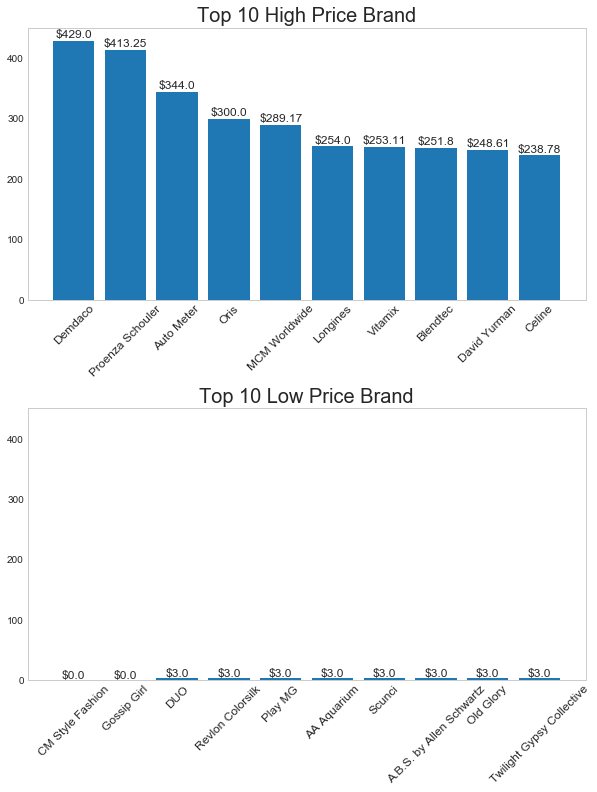

In [431]:
fig,(ax8,ax9) = plt.subplots(nrows = 2,figsize = (10,12),sharey = True)
ax8.grid(b = False)
ax9.grid(b = False)
a1 = ax8.bar(range(len(top10_high)),top10_high['price'])
a2 = ax9.bar(range(len(top10_low)),top10_low['price'])
ax8.set_xticks(range(len(top10_high)))
ax8.set_xticklabels(top10_high.index,rotation = 45,fontsize = 12)
ax9.set_xticks(range(len(top10_low)))
ax9.set_xticklabels(top10_low.index,rotation = 45,fontsize = 12)
ax8.set_title('Top 10 High Price Brand',fontsize = 20)
ax9.set_title('Top 10 Low Price Brand',fontsize = 20)
#ax8.axis('off')
#ax9.axis('off')
for i in range(len(top10_high)):
    x_co_price_high = a1.patches[i].get_x()+a1.patches[i].get_width()/2
    y_co_price_high = a1.patches[i].get_height()+2
    x_co_price_low = a2.patches[i].get_x()+a2.patches[i].get_width()/2
    y_co_price_low = a2.patches[i].get_height()
    ax8.text(x_co_price_high,y_co_price_high,'$'+str(np.round(top10_high['price'][i],2)),ha = 'center',va = 'bottom',size = 12)
    ax9.text(x_co_price_low,y_co_price_low,'$'+str(np.round(top10_low['price'][i],2)),ha = 'center',va = 'bottom',size = 12)
plt.subplots_adjust(hspace = 0.4)
plt.show()

By checking all the brands either in upper side or lower side, we realized that these brands are all not commonly seen brands. Among the top 10 high price brands, we could see various of category those brand belong to, we found bag brands, blender brands, handmade craft brands, jewelry brands, and watch brands. By googleing the brands in the lower side, we found that some brands are even absent from the searching results. What is more wield is that the top 2 brands are selling things for free. Let's dive into this issue and check.

In [481]:
train[(train['brand_name']=='CM Style Fashion') | (train['brand_name']=='Gossip Girl')]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
747867,747867,BNWT! Gossip Girl Swim Suit! Free Ship!,1,Women/Swimwear/Two-Piece,Gossip Girl,0.0,1,BNWT! Top is a size small and bottoms are a si...
1363442,1363442,rain jacket,2,Women/Coats & Jackets/Raincoat,CM Style Fashion,0.0,0,No description yet


The top 2 low price brands have only 1 records for each of them. We think these kind of records could be considered as noises. We might consider eliminate them when training models.

As we uncovered, more than 40 persent of items in our data set is lack of brand name. We would be happy to answer, is there any difference between these items and those ones with brand names. Here, we are going to check whether there is a gap on price between these two groups.

In [450]:
null_brand = train[['category_name','price']]
null_brand['null_brand'] = (train['brand_name'].isnull())*1

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


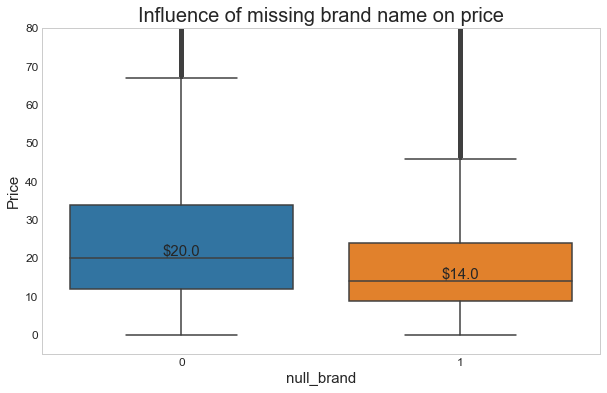

In [449]:
#sns.set_style("whitegrid")
plt.figure(figsize = (10,6))
ax10 = sns.boxplot(x = 'null_brand',y = 'price',data = null_brand)
plt.grid('off')
ax10.set_ylim(-5,80)
medians = null_brand.groupby('null_brand')['price'].median().values
for i in range(len(medians)):
    x_co = i
    y_co = medians[i]
    text_label = medians[i]
    plt.text(x_co,y_co,'$'+str(text_label),ha = 'center',va = 'bottom',size = 15)
plt.xlabel('null_brand',fontsize = 15)
plt.ylabel('Price',fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Influence of missing brand name on price',fontsize = 20)

We found that the median price for items without a brand name is only \$14, which is far lower than the \$20 of items with a brand name. This is an interesting finding. Both groups contain huge amounts of records, so the possibility that this outcome is by chance is very small. One plausible explannation is that items miss their brand names are made by unwellknown companies so that they have to be sold cheaper than products with wellknown manufacturers.

To dig out more details, we would like to find out what are the top frequent categories in both of the groups, namely, with or without brand names.

In [456]:
null_brand_cat = null_brand[null_brand['null_brand']==1]['category_name'].value_counts()[:10]
not_null_brand_cat = null_brand[null_brand['null_brand']==0]['category_name'].value_counts()[:10]

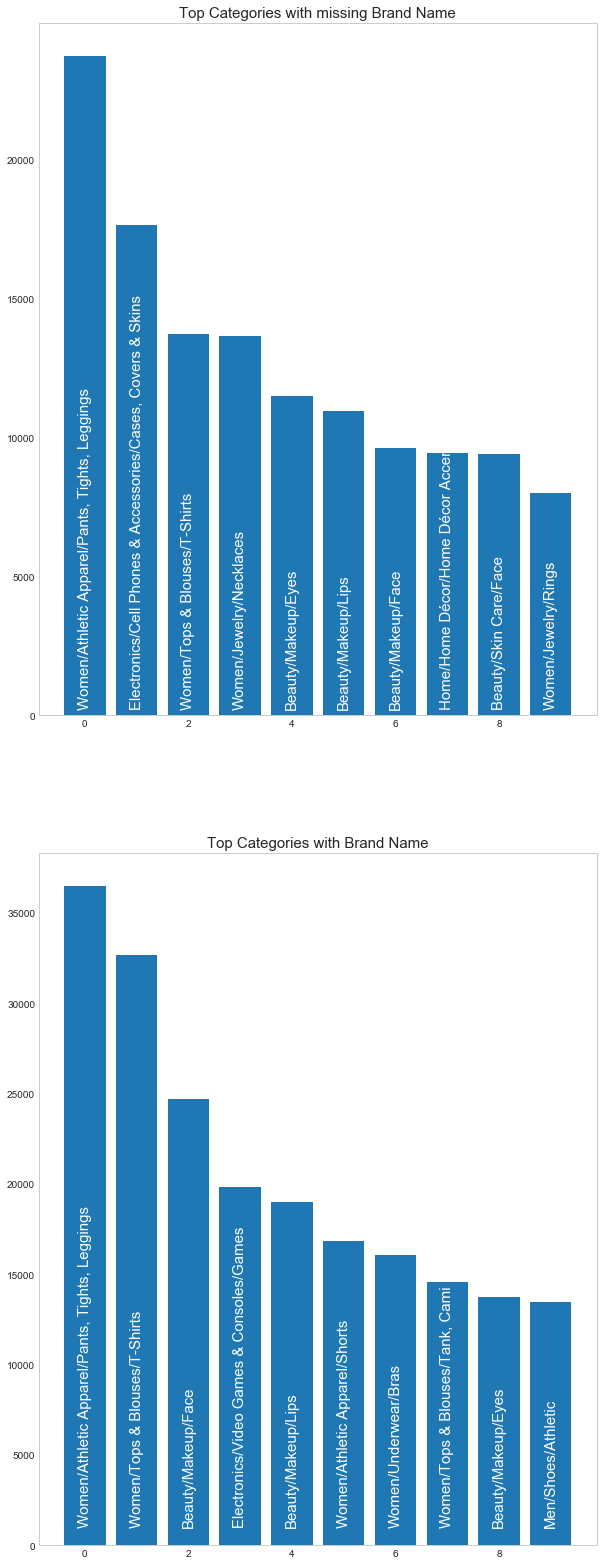

In [480]:
fig,(ax11,ax12) = plt.subplots(nrows = 2,figsize = (10,28))
ax11.bar(range(len(null_brand_cat)),null_brand_cat)
ax12.bar(range(len(not_null_brand_cat)),not_null_brand_cat)
ax11.set_title('Top Categories with missing Brand Name',fontsize = 15)
ax12.set_title('Top Categories with Brand Name',fontsize = 15)
ax11.grid('off')
ax12.grid('off')
for i in range(len(null_brand_cat)):
    ax11_col_x = ax11.patches[i].get_x()+ax11.patches[i].get_width()/2
    ax11_col_y = 200
    ax12_col_x = ax12.patches[i].get_x()+ax12.patches[i].get_width()/2
    ax12_col_y = 1000
    ax11.text(ax11_col_x,ax11_col_y,null_brand_cat.index[i],rotation = 90,color = 'white',ha = 'center',va = 'bottom',size = 15)
    ax12.text(ax12_col_x,ax12_col_y,not_null_brand_cat.index[i],rotation = 90,color = 'white',ha = 'center',va = 'bottom',size = 15)
plt.show()

There is not much difference between these two groups.

### 6.shipping column

The most main question we got when we face with this column is that whether the shipping commitment would influence the price of the an item. Now we would like to answer it. 1 is shipping fee paid by seller and 0 by buyer. 

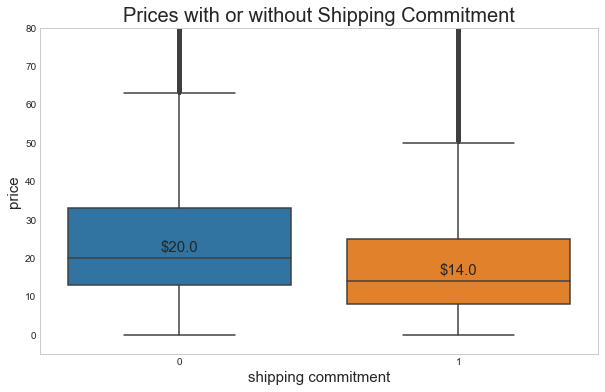

In [499]:
medians = train.groupby('shipping')['price'].median().values
plt.figure(figsize = (10,6))
a3 = sns.boxplot(x = 'shipping', y = 'price', data = train)
a3.set_ylim(-5,80)
plt.grid('off')
for i in range(len(medians)):
    x_co = i
    y_co = medians[i]+1
    s = '$'+str(medians[i])
    a3.text(x_co,y_co,s,ha = 'center',va = 'bottom',size = 15)
a3.set_ylabel('price',fontsize = 15)
a3.set_xlabel('shipping commitment',fontsize = 15)
a3.set_title('Prices with or without Shipping Commitment',fontsize = 20)
plt.show()

This result is contrary to what we expected. We thought that sellers who made shipping commitment might charge higher prices on items then those who didn't. The fact is a reverse. The sellers commited to pay shipping fee charge \$6 lower than those who didn't. 

### 7.item_description column

In previous investigations, we found that lots of duplicates are exist in item_descriptions. So, first we are going to identify these duplicates by looking at the top frequent records in item_description.

In [507]:
top_description = train['item_description'].value_counts()[:10]
top_description_per = (train['item_description'].value_counts()/train.shape[0])[:10]

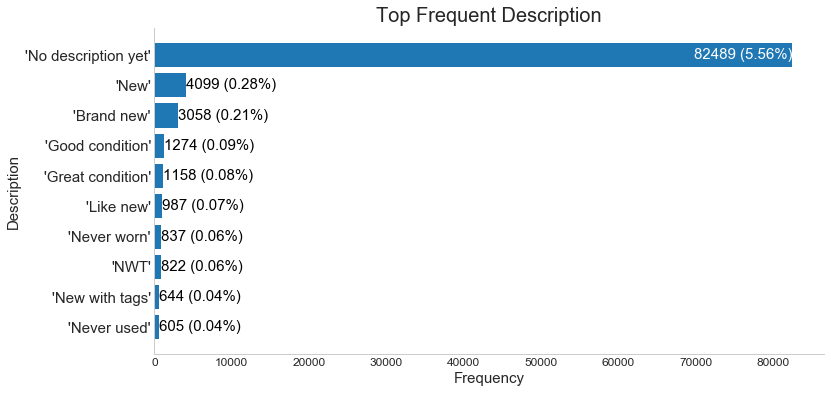

In [565]:
plt.figure(figsize = (12,6))
a4 = plt.barh(range(len(top_description)),top_description)
plt.gca().invert_yaxis()
plt.grid('off')
ax13 = plt.gca()
ax13.set_yticks(range(len(top_description)))
ax13.set_yticklabels(["'"+str(i)+"'" for i in top_description.index],fontsize = 15)
for i in range(len(top_description)):
    if top_description[i]>30000:
        ha = 'right'
        color = 'white'
    else:
        ha = 'left'
        color = 'black'
    x_co = ax13.patches[i].get_width()
    y_co = ax13.patches[i].get_y()+ax13.patches[i].get_height()/2
    s = str(top_description[i])+' ('+str(np.round(top_description_per[i]*100,2))+'%)'
    ax13.text(x_co,y_co,s,va = 'center',ha = ha,color = color,size = 15)
ax13.spines['top'].set_visible(False)
ax13.spines['right'].set_visible(False)
ax13.set_xlabel('Frequency',fontsize = 15)
ax13.set_ylabel('Description',fontsize = 15)
ax13.set_title('Top Frequent Description',fontsize = 20)
ax13.set_xticklabels(ax13.get_xticks().astype(int),fontsize = 12)
plt.show()

From the result, we could tell that the most frequent item description is 'No description yet'. This string does not seem like something added by sellers. So, we are going to regard them as missing values. Other top frequent descriptions are very short descriptions like 'New', 'Brand new', and 'Good Condition'.

Is there any difference in price between 'No description yet' items and other items?

In [8]:
no_description = train[['price']]
no_description['no_description'] = (train['item_description']=='No description yet')*1
medians = no_description.groupby('no_description')['price'].median().values

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


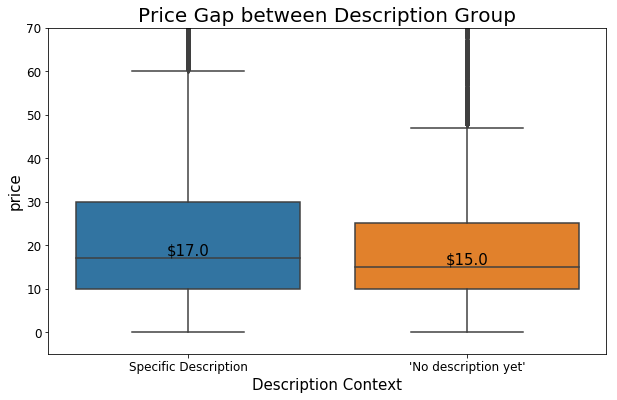

In [35]:
plt.figure(figsize = (10,6))
a14 = sns.boxplot(x = 'no_description',y = 'price',data = no_description)
a14.set_xticklabels(['Specific Description', "'No description yet'"],fontsize  =12)
plt.yticks(fontsize = 12)
plt.ylim(-5,70)
plt.ylabel('price',fontsize = 15)
plt.xlabel('Description Context',fontsize = 15)
plt.title('Price Gap between Description Group',fontsize = 20)
for i in range(len(medians)):
    x_co = i
    y_co = medians[i]
    a14.text(x_co,y_co,'$'+str(medians[i]),ha = 'center',va = 'bottom',size = 15)
plt.show()

It seems that items with a 'No description yet' description would have a slightly lower price than those who got specific descriptions. 

Considering that the lenth of description may reflect the degree of confidence a seller has on his selling product. We would like to see is there any correlation between the number of words in description and the price. Here, we would wipe out the items with description of 'no description yet' as we regard these descriptions as missing values.

In [580]:
description_price = train[(train['item_description']!='No description yet') & (train['item_description'].notnull())]
word_count = description_price['item_description'].apply(lambda x:len(x.split()))
description_price['word_count'] = word_count

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


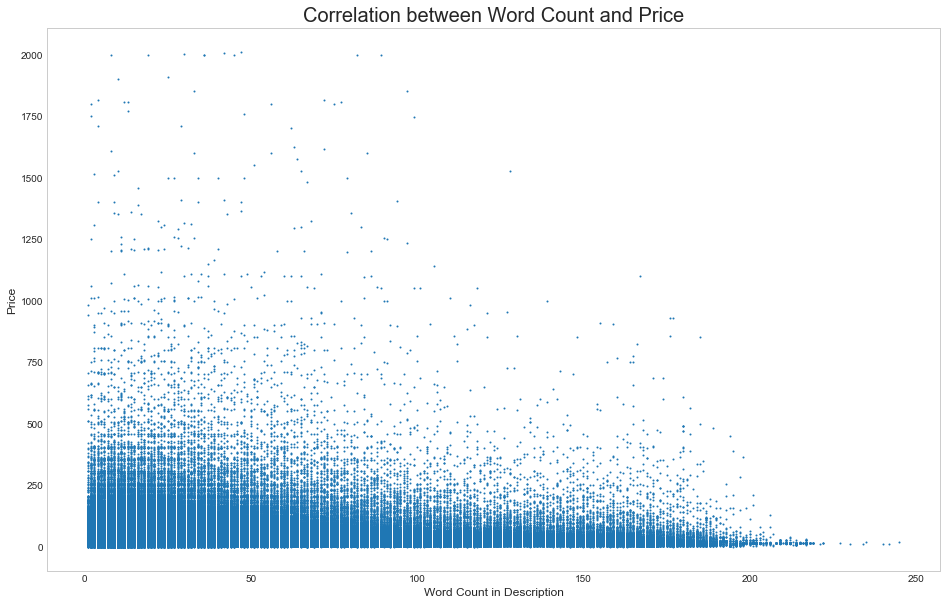

In [585]:
plt.figure(figsize = (16,10))
plt.scatter(description_price['word_count'],description_price['price'],s = 1)
plt.grid('off')
plt.xlabel('Word Count in Description',fontsize = 12)
plt.ylabel('Price',fontsize = 12)
plt.title('Correlation between Word Count and Price',fontsize = 20)
plt.show()

In [591]:
x = description_price['word_count']
x = sm.add_constant(x)
y = description_price['price']
model = sm.OLS(y,x)
results = model.fit()

In [594]:
results.params

const         25.492365
word_count     0.056546
dtype: float64

In [602]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2783.
Date:                Mon, 12 Feb 2018   Prob (F-statistic):               0.00
Time:                        23:14:41   Log-Likelihood:            -7.1161e+06
No. Observations:             1400042   AIC:                         1.423e+07
Df Residuals:                 1400040   BIC:                         1.423e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         25.4924      0.044    580.861      0.000        25.406    25.578
word_count     0.0565      0.001     52.755      0.000         0.054     0.059
==============================================================================
Omnibus:                  2361968.290   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4582780793.560
Skew:                          11.292   Prob(JB):                         0.00
Kurtosis:                     282.374   Cond. No.                         54.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the plot, we recognized a decreasing trend on price as description gets longer. This is in contrast with what we expected. And the ordinary least square report also indicates there is no strong correlation between the word count and price, as suggested by R square value of 0.002. Maybe most people just don't bother to write long descriptions.

We were informed that the sellers were marking item prices in description context in original data. However, the competition holder replace these pieces of prices by '[rm]' to avoid data leakage. There is an example shown below.

In [115]:
train['item_description'][3]

'New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage'

We wonder is there any chance that the sellers put the price information in the description out of some reason that they are confident in the prices they were charging.

In [113]:
rm_test = train.copy()
rm_test['item_description'] = rm_test['item_description'].fillna(value = 'No description yet')
rm_test['[rm]_in_description'] = rm_test['item_description'].apply(lambda x:1 if '[rm]' in x else 0)

In [116]:
medians = rm_test.groupby('[rm]_in_description')['price'].median().values

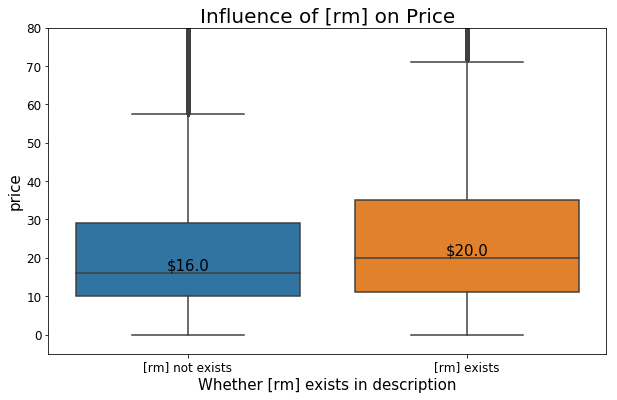

In [118]:
plt.figure(figsize = (10,6))
a15 = sns.boxplot(x = '[rm]_in_description',y = 'price',data = rm_test)
a15.set_xticklabels(['[rm] not exists', "[rm] exists"],fontsize  =12)
plt.yticks(fontsize = 12)
plt.ylim(-5,80)
plt.ylabel('price',fontsize = 15)
plt.xlabel('Whether [rm] exists in description',fontsize = 15)
plt.title('Influence of [rm] on Price',fontsize = 20)
for i in range(len(medians)):
    x_co = i
    y_co = medians[i]
    a15.text(x_co,y_co,'$'+str(medians[i]),ha = 'center',va = 'bottom',size = 15)
plt.show()

The result does not go alignment with our assumption since items with '[rm]' in item description were more expensive. The good news is, although we don't know the reason yet, it seems there is a significant difference between these two groups.

The next question is, is the appearance of brand names in item description also makes a difference on price to be charged.

In [145]:
brand_in_description = train[['brand_name','price','item_description']]
brand_in_description = brand_in_description[brand_in_description['brand_name'].notnull()]
brand_in_description['item_description'] = brand_in_description['item_description'].fillna(value = 'No description yet')

In [151]:
b_in_d = brand_in_description.apply(lambda x:1 if (x[0] in x[2]) or (x[0].lower() in x[2]) or (x[0].title() in x[2]) else 0,axis = 1)

In [153]:
brand_in_description['brand_in_description'] = b_in_d

In [158]:
medians = brand_in_description.groupby('brand_in_description')['price'].median().values

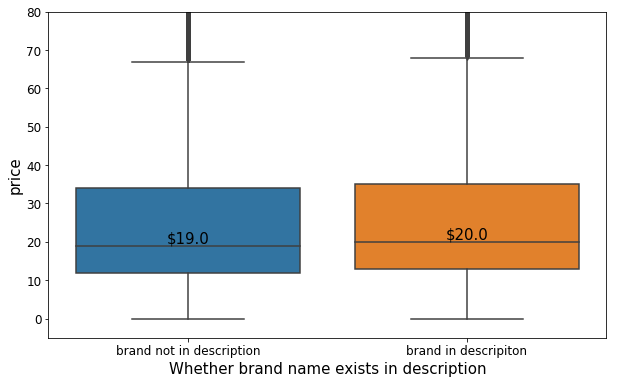

In [159]:
plt.figure(figsize = (10,6))
a16 = sns.boxplot(x = 'brand_in_description',y = 'price',data = brand_in_description)
a16.set_xticklabels(['brand not in description', "brand in descripiton"],fontsize  =12)
plt.yticks(fontsize = 12)
plt.ylim(-5,80)
plt.ylabel('price',fontsize = 15)
plt.xlabel('Whether brand name exists in description',fontsize = 15)
#plt.title('Influence of [rm] on Price',fontsize = 20)
for i in range(len(medians)):
    x_co = i
    y_co = medians[i]
    a16.text(x_co,y_co,'$'+str(medians[i]),ha = 'center',va = 'bottom',size = 15)
plt.show()

Seems there is not much difference between these two groups